In [6]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import xarray as xr

In [7]:
finput_mean = "./data/aibedo_data/ymonmean.1980_2010.isosph.CMIP6.historical.ensmean.Input.Exp8_fixed.nc"
finput_std = "./data/aibedo_data/ymonstd.1980_2010.isosph.CMIP6.historical.ensmean.Input.Exp8_fixed.nc"
foutput_mean = "./data/aibedo_data/ymonmean.1980_2010.isosph.CMIP6.historical.ensmean.Output.nc"
foutput_std = "./data/aibedo_data/ymonstd.1980_2010.isosph.CMIP6.historical.ensmean.Output.nc"
finput_file = "./data/aibedo_data/compress.isosph.CESM2.historical.r1i1p1f1.Input.Exp8_fixed.nc"
foutput_file = "./data/aibedo_data/compress.isosph.CESM2.historical.r1i1p1f1.Output.nc"

In [10]:
dsinput_mean = xr.open_dataset(finput_mean)
dsinput_std = xr.open_dataset(finput_std)
dsoutput_mean = xr.open_dataset(foutput_mean)
dsoutput_std = xr.open_dataset(foutput_std)
ds_output = xr.open_dataset(foutput_file)

In [11]:
tas_mean = np.array(dsoutput_mean.tas)
pr_mean = np.array(dsoutput_mean.pr)
psl_mean = np.array(dsoutput_mean.psl)
##
taspre_mean = np.array(dsoutput_mean.tas_pre)
prpre_mean = np.array(dsoutput_mean.pr_pre)
pslpre_mean = np.array(dsoutput_mean.psl_pre)
##
pr = np.array(ds_output.pr)
tas = np.array(ds_output.tas)
psl = np.array(ds_output.psl)

In [12]:
b = np.zeros(tas.shape[0])
tas_onehot = np.concatenate((tas, b.reshape(-1,1)), axis = 1)
pr_onehot = np.concatenate((pr, b.reshape(-1,1)), axis = 1)
psl_onehot = np.concatenate((psl, b.reshape(-1,1)), axis = 1)

In [13]:
def oneHotEncode(field):
    q = 0
    j = 0
    for i in range(field.shape[0]):
        if i == 0:
            field[j, -1] = i
        else:
            q = i // 12
            i = i - q*12
            j = j + 1
            field[j, -1] = i
    
    return field

In [14]:
tas_onehot2 = oneHotEncode(tas_onehot)
pr_onehot2 = oneHotEncode(pr_onehot)
psl_onehot2 = oneHotEncode(psl_onehot)
data_out = np.dstack((tas_onehot2, pr_onehot2, psl_onehot2))

In [15]:
data_out.shape

(1980, 40963, 3)

In [17]:
print(np.max(tas_onehot2[:,-1]))
print(np.max(pr_onehot2[:,-1]))
print(np.max(psl_onehot2[:,-1]))

0.0
11.0
11.0


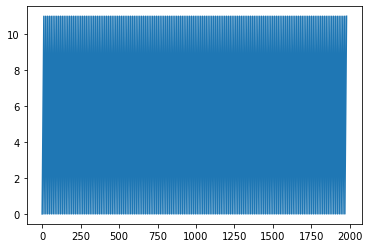

In [18]:
plt.plot(tas_onehot2[:,-1])

In [29]:
def loadValPre(foutput_mean, foutput_std):
    dsoutput_mean = xr.open_dataset(foutput_mean)
    dsoutput_std = xr.open_dataset(foutput_std)
    
    tas_mean = np.array(dsoutput_mean.tas_pre)
    pr_mean = np.array(dsoutput_mean.pr_pre)
    psl_mean = np.array(dsoutput_mean.psl_pre)
    
    tas_std = np.array(dsoutput_std.tas_pre)
    pr_std = np.array(dsoutput_std.pr_pre)
    psl_std = np.array(dsoutput_std.psl_pre)
    
    normVal = np.dstack((tas_mean, tas_std, psl_mean, psl_std, pr_mean, pr_std))
                        
    return normVal


def loadVal(foutput_mean, foutput_std):
    dsoutput_mean = xr.open_dataset(foutput_mean)
    dsoutput_std = xr.open_dataset(foutput_std)
    
    tas_mean = np.array(dsoutput_mean.tas)
    pr_mean = np.array(dsoutput_mean.pr)
    psl_mean = np.array(dsoutput_mean.psl)
    
    tas_std = np.array(dsoutput_std.tas)
    pr_std = np.array(dsoutput_std.pr)
    psl_std = np.array(dsoutput_std.psl)
    
    normVal = np.dstack((tas_mean, tas_std, psl_mean, psl_std, pr_mean, pr_std))
                        
    return normVal

In [30]:
normVal = loadVal(foutput_mean, foutput_std)
normValPre = loadValPre(foutput_mean, foutput_std)

In [31]:
data_out = np.dstack((tas_onehot2, psl_onehot2, pr_onehot2))
data_out_unscaled = np.zeros_like(data_out)
data_out_unscaledPre = np.zeros_like(data_out)

for i in range(data_out.shape[0]):
    
    idx = data_out[i,-1,0]
    
    data_out_unscaled[i,0:int(data_out.shape[1])-1, 0] = data_out[i,0:int(data_out.shape[1])-1, 0] * normVal[int(idx),:, 1] + normVal[int(idx),:, 0]
    data_out_unscaled[i,0:int(data_out.shape[1])-1, 1] = data_out[i,0:int(data_out.shape[1])-1, 1] * normVal[int(idx),:, 3] + normVal[int(idx),:, 2]
    data_out_unscaled[i,0:int(data_out.shape[1])-1, 2] = data_out[i,0:int(data_out.shape[1])-1, 2] * normVal[int(idx),:, 5] + normVal[int(idx),:, 4]
    
    
    data_out_unscaledPre[i,0:int(data_out.shape[1])-1, 0] = data_out[i,0:int(data_out.shape[1])-1, 0] * normValPre[int(idx),:, 1] + normValPre[int(idx),:, 0]
    data_out_unscaledPre[i,0:int(data_out.shape[1])-1, 1] = data_out[i,0:int(data_out.shape[1])-1, 1] * normValPre[int(idx),:, 3] + normValPre[int(idx),:, 2]
    data_out_unscaledPre[i,0:int(data_out.shape[1])-1, 2] = data_out[i,0:int(data_out.shape[1])-1, 2] * normValPre[int(idx),:, 5] + normValPre[int(idx),:, 4]
    
    

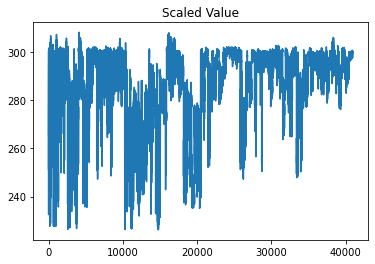

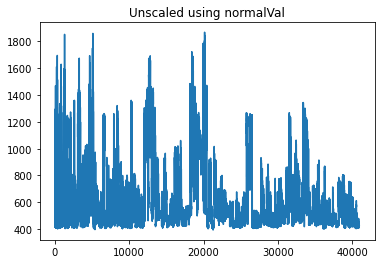

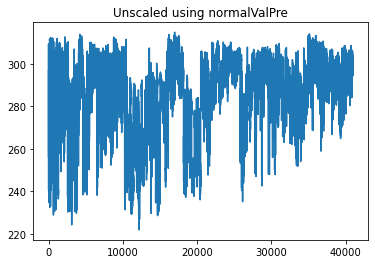

In [37]:
plt.figure()
plt.title('Scaled Value')
plt.plot(data_out[1,0:int(data_out.shape[1])-1,0])
plt.figure()
plt.title('Unscaled using normalVal')
plt.plot(data_out_unscaled[1,0:int(data_out.shape[1])-1,0])
plt.figure()
plt.title('Unscaled using normalValPre')
plt.plot(data_out_unscaledPre[1,0:int(data_out.shape[1])-1,0])

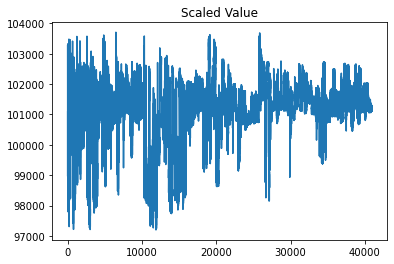

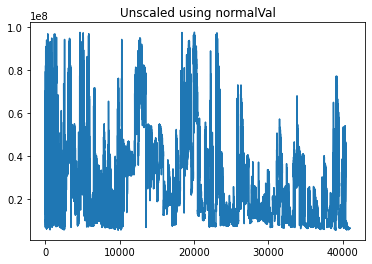

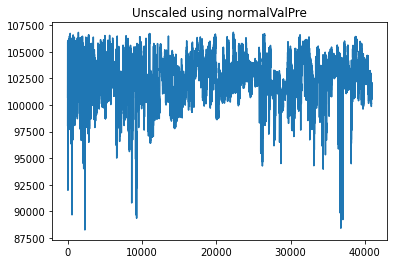

In [38]:
plt.figure()
plt.title('Scaled Value')
plt.plot(data_out[1,0:int(data_out.shape[1])-1,1])
plt.figure()
plt.title('Unscaled using normalVal')
plt.plot(data_out_unscaled[1,0:int(data_out.shape[1])-1,1])
plt.figure()
plt.title('Unscaled using normalValPre')
plt.plot(data_out_unscaledPre[1,0:int(data_out.shape[1])-1,1])

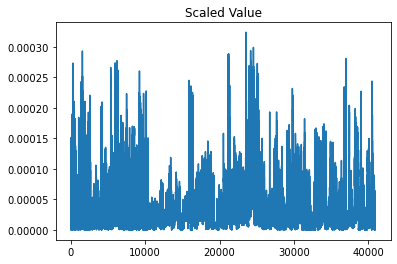

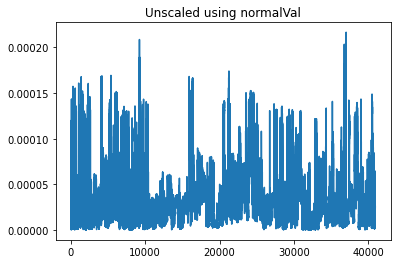

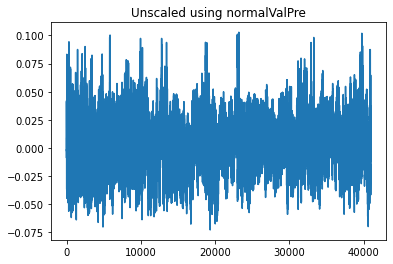

In [39]:
plt.figure()
plt.title('Scaled Value')
plt.plot(data_out[1,0:int(data_out.shape[1])-1,2])
plt.figure()
plt.title('Unscaled using normalVal')
plt.plot(data_out_unscaled[1,0:int(data_out.shape[1])-1,2])
plt.figure()
plt.title('Unscaled using normalValPre')
plt.plot(data_out_unscaledPre[1,0:int(data_out.shape[1])-1,2])